```{contents}
```
## **Load-Based Routing in LangGraph**

**Load-based routing** in LangGraph is a **dynamic control-flow mechanism** where the next node (or agent) is selected at runtime based on **system load, resource availability, performance metrics, or cost constraints**.
It enables **scalable, high-throughput, production-grade LLM systems**.

---

### **1. Motivation**

Traditional routing uses only **task semantics**.
Load-based routing incorporates **system conditions**:

| Dimension   | Why It Matters                    |
| ----------- | --------------------------------- |
| Latency     | Prevent slow responses            |
| Throughput  | Handle traffic spikes             |
| Cost        | Route to cheaper models when busy |
| Reliability | Avoid overloaded components       |
| Fairness    | Balance workload across agents    |

---

### **2. Conceptual Model**

```
           ┌─────────────┐
Request →  │ Load Router │
           └──────┬──────┘
                  ↓
      ┌──────────┬──────────┬──────────┐
   Agent A    Agent B    Agent C    (parallel workers)
 (Low load)  (High load) (Medium)
```

Router selects the target with **lowest effective cost**.

---

### **3. What Is "Load" in LangGraph?**

Load is represented in the **shared state**:

| Metric       | Example                        |
| ------------ | ------------------------------ |
| Active tasks | Number of in-flight executions |
| Latency      | Moving average response time   |
| Error rate   | Failure frequency              |
| Queue length | Pending jobs                   |
| Token usage  | Current token burn             |
| Cost         | Dollar usage per minute        |

```python
class State(TypedDict):
    task: str
    load_A: float
    load_B: float
    load_C: float
```

---

### **4. Implementing Load-Based Routing**

### **Router Function**

```python
def route_by_load(state):
    loads = {
        "agent_A": state["load_A"],
        "agent_B": state["load_B"],
        "agent_C": state["load_C"],
    }
    return min(loads, key=loads.get)
```

### **Graph Construction**

```python
builder.add_node("router", route_by_load)
builder.add_node("agent_A", agent_A)
builder.add_node("agent_B", agent_B)
builder.add_node("agent_C", agent_C)

builder.set_entry_point("router")

builder.add_conditional_edges("router", route_by_load, {
    "agent_A": "agent_A",
    "agent_B": "agent_B",
    "agent_C": "agent_C",
})
```

---

### **5. Updating Load Dynamically**

Each agent reports back:

```python
def agent_A(state):
    result = do_work()
    return {
        "result": result,
        "load_A": state["load_A"] + 1
    }
```

State reducers smooth noisy metrics:

```python
def smooth(old, new):
    return 0.8 * old + 0.2 * new
```

---

### **6. Production Routing Policies**

| Policy        | Rule                     |
| ------------- | ------------------------ |
| Least-Load    | Choose minimal load      |
| Latency-Aware | Prefer lowest latency    |
| Cost-Aware    | Prefer cheapest model    |
| Weighted      | Combine multiple factors |
| Failover      | Skip unhealthy nodes     |
| Quota-Aware   | Respect budget limits    |

### **Weighted Decision Example**

```python
score = 0.5 * latency + 0.3 * cost + 0.2 * queue
```

---

### **7. Variants of Load-Based Routing**

| Variant             | Use Case                   |
| ------------------- | -------------------------- |
| Worker Pool Routing | Distribute tasks           |
| Model Router        | Switch LLM providers       |
| Agent Router        | Multi-agent load balancing |
| Tool Router         | Balance expensive tools    |
| Hybrid Router       | Combine semantics + load   |

---

### **8. Safety & Stability Controls**

| Mechanism         | Purpose             |
| ----------------- | ------------------- |
| Circuit Breaker   | Avoid failing nodes |
| Backpressure      | Prevent overload    |
| Rate Limiting     | Protect APIs        |
| Timeouts          | Avoid blocking      |
| Retry with jitter | Smooth spikes       |
| Quotas            | Cost containment    |

---

### **9. Real-World Example**

**LLM Serving Platform**

```
User → Load Router → GPT-4 / Claude / Llama → Response
```

Routing considers:

* Current latency
* Token cost
* Error rate
* SLA targets

---

### **10. Why This Matters**

Load-based routing turns LangGraph from a workflow engine into a **self-regulating distributed AI system**.

It enables:

* High availability
* Cost efficiency
* Automatic scaling
* Production reliability


### Demonstration

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict
import random, time

# -----------------------------
# 1. Shared State
# -----------------------------
class State(TypedDict):
    task: str
    load_A: float
    load_B: float
    load_C: float
    result: str

# -----------------------------
# 2. Workers
# -----------------------------
def agent_A(state):
    time.sleep(0.2)
    return {"result": f"A handled {state['task']}", "load_A": state["load_A"] + random.random()}

def agent_B(state):
    time.sleep(0.4)
    return {"result": f"B handled {state['task']}", "load_B": state["load_B"] + random.random()}

def agent_C(state):
    time.sleep(0.1)
    return {"result": f"C handled {state['task']}", "load_C": state["load_C"] + random.random()}

# -----------------------------
# 3. Router Logic
# -----------------------------
def choose_route(state):
    loads = {
        "agent_A": state["load_A"],
        "agent_B": state["load_B"],
        "agent_C": state["load_C"],
    }
    return min(loads, key=loads.get)

def router_node(state):
    return {}  # router node only passes state through

# -----------------------------
# 4. Graph
# -----------------------------
builder = StateGraph(State)

builder.add_node("router", router_node)
builder.add_node("agent_A", agent_A)
builder.add_node("agent_B", agent_B)
builder.add_node("agent_C", agent_C)

builder.set_entry_point("router")

builder.add_conditional_edges("router", choose_route, {
    "agent_A": "agent_A",
    "agent_B": "agent_B",
    "agent_C": "agent_C",
})

builder.add_edge("agent_A", END)
builder.add_edge("agent_B", END)
builder.add_edge("agent_C", END)

graph = builder.compile()

# -----------------------------
# 5. Run
# -----------------------------
state = {
    "task": "analyze report",
    "load_A": 0.6,
    "load_B": 0.9,
    "load_C": 0.2,
    "result": ""
}

print(graph.invoke(state))


{'task': 'analyze report', 'load_A': 0.6, 'load_B': 0.9, 'load_C': 1.1276148604263565, 'result': 'C handled analyze report'}


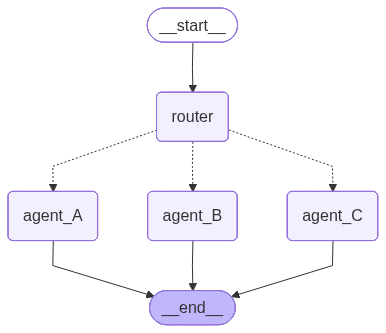

In [3]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())